In [1]:
%matplotlib inline
import numpy as np

In [3]:
def fetch(url):
    import requests, gzip, os, hashlib

    cache_dir = os.path.join(os.getcwd(), ".cache")
    if not os.path.isdir(cache_dir):
        os.mkdir(cache_dir)

    fp = os.path.join(cache_dir, hashlib.md5(url.encode('utf-8')).hexdigest())
    if os.path.isfile(fp):
        with open(fp, "rb") as f:
            dat = f.read()
    else:
        with open(fp, "wb") as f:
            dat = requests.get(url).content
            f.write(dat)
    return np.frombuffer(gzip.decompress(dat), dtype=np.uint8)

X_train = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[16:].reshape((-1, 28, 28)).astype(np.float32) / 255
Y_train = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[16:].reshape((-1, 28, 28)).astype(np.float32) / 255
Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import tensor
from tqdm import trange
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

In [5]:
class SmolNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(28 * 28, 128, bias=False)
        self.l2 = nn.Linear(128, 10, bias=False)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.log_softmax(self.l2(x), dim=1)
        return x

model = SmolNet()

loss=0.26, acc=0.906250: 100%|██████████| 1000/1000 [00:01<00:00, 508.39it/s]


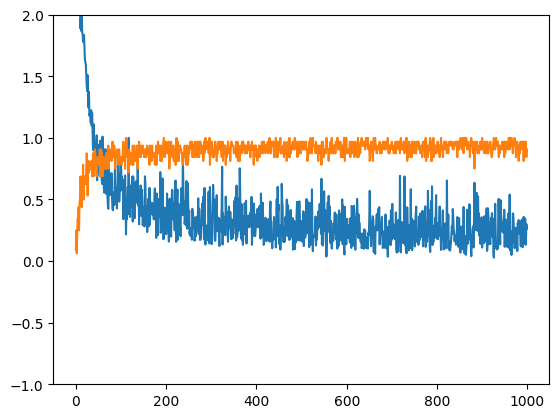

In [6]:
# train
BATCH = 32
loss_func = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())
accuracies = []
losses = []
for i in (t := trange(1000)):
    # prepare data
    samp = np.random.randint(0, X_train.shape[0], size=(BATCH))
    X = tensor(X_train[samp], requires_grad=True).reshape((-1, 28*28))
    Y = tensor(Y_train[samp]).long()

    # train
    optimizer.zero_grad()
    out = model(X)
    pred = out.argmax(axis=1)
    acc = (pred == Y).float().mean()
    loss = F.nll_loss(out, Y)
    loss.backward()
    optimizer.step()

    # stat
    acc, loss = acc.item(), loss.item()
    accuracies.append(acc)
    losses.append(loss)
    t.set_description('loss={:.2f}, acc={:2f}'.format(loss, acc))

plt.ylim(-1, 2)
plt.plot(losses)
plt.plot(accuracies)


In [7]:
# pytorch version evaluation
X = tensor(X_test).reshape((-1, 28*28))
Y = tensor(Y_test)
out = model(X)
pred = out.argmax(axis=1)
acc = (Y == pred).float().mean()
acc, X_test.shape[0]

(tensor(0.9369), 10000)

In [8]:
# copy model from pytorch to numpy
l1 = np.zeros((28*28, 128), dtype=np.float32)
l2 = np.zeros((128, 10), dtype=np.float32)
l1[:] = model.l1.weight.detach().numpy().transpose()
l2[:] = model.l2.weight.detach().numpy().transpose()

In [9]:
# smolgrad forward
def forward(x):
    x = x.dot(l1)
    x = np.maximum(0, x) # relu
    x = x.dot(l2)

    # log softmax
    den = np.log(np.exp(x).sum())
    x = np.log(np.exp(x)) - den

    return x

def forward_no_sig(x):
    x = x.dot(l1)
    x = np.maximum(0, x) # relu
    x = x.dot(l2)

    return x


In [10]:
# check on test set make sure forward matches
#tor = model(tensor(X_train.reshape((-1, 28*28)))).argmax(axis=1).numpy()
ours = forward(X_test.reshape((-1, 28*28))).argmax(axis=1)
(ours == Y_test).mean()

0.9369

In [11]:
# prepare train data
X = X_train.reshape((-1, 28*28))
Y = Y_train

# predict
out = forward(X)
pred = out.argmax(axis=1)

# nll loss
G = 16
#loss = -np.log(np.exp(out[range(out.shape[0]), Y]) / np.exp(out).sum(axis=1))
loss = -out[range(out.shape[0]), Y]


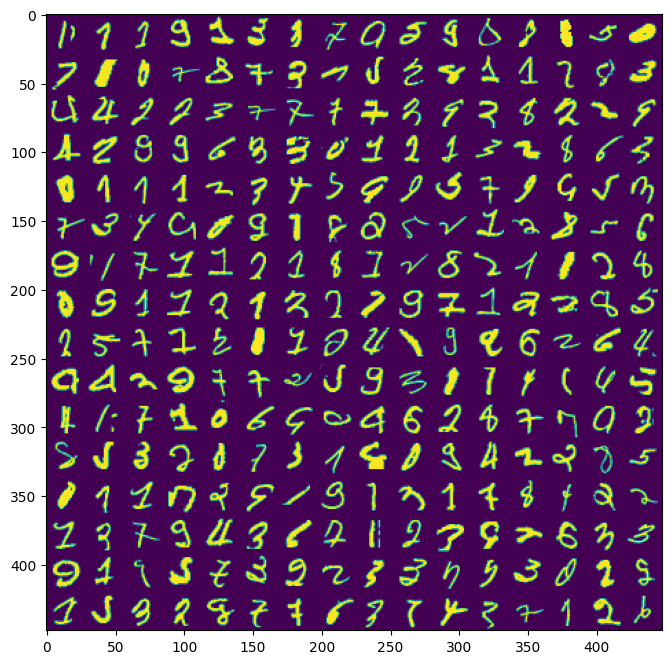

In [12]:
# show some cursed digits, based on loss on training test
messup = sorted(zip(loss, range(out.shape[0])), key=lambda x: x[0], reverse=True)
X_bad = X_train[[x[1] for x in messup[:G*G]]]
plt.figure(figsize=(8,8))
imshow(np.concatenate(X_bad.reshape((G, 28 * G, 28)), axis=1))

tensor([[ -9.3306, -11.7059,  -9.3536,  -2.5547, -17.4864,  -0.0821, -13.8135,
          -7.2374,  -9.3532,  -9.0353]], grad_fn=<LogSoftmaxBackward0>)
loss grad tensor(1.)
log_softmax grad tensor([[ 0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.]])
l2 grad tensor([[ 8.8670e-05,  8.2449e-06,  8.6651e-05,  7.7719e-02,  2.5454e-08,
         -7.8828e-02,  1.0020e-06,  7.1921e-04,  8.6691e-05,  1.1913e-04]])
torch.Size([10, 128])


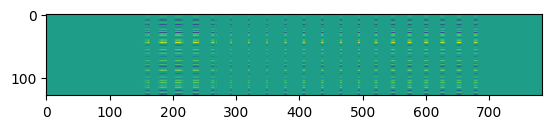

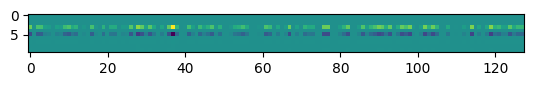

In [51]:
# backward, pytorch reference

model.zero_grad()

x = tensor(X_train[0:1].reshape((-1, 28*28)))
ml1 = model.l1(x)
mrelu = F.relu(ml1)
ml2 = model.l2(mrelu)
ml2.retain_grad()
msoft = F.log_softmax(ml2, dim=1)
out = msoft

print(out)

#out = model(tensor(X_train[0:1].reshape((-1, 28*28))))
#out = smol_forword(tensor(X_train[0:1].reshape((-1, 28*28))))
out.retain_grad()

loss = F.nll_loss(out, tensor(Y_train[0:1]))
loss.retain_grad()
loss.backward()

print('loss grad', loss.grad)
print('log_softmax grad', out.grad)
print('l2 grad', ml2.grad)

plt.figure()
imshow(model.l1.weight.grad)
plt.figure()
imshow(model.l2.weight.grad)
model.l2.weight.grad

print(model.l2.weight.shape)

(1, 128) (1, 784) (784, 128)
(1, 10) (1, 128) (128, 10)
[[ -9.330589   -11.705918    -9.353628    -2.5546606  -17.486382
   -0.08210897 -13.813511    -7.237353    -9.353163    -9.035263  ]]
tensor([[ 0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.]])
tensor([[ 8.8670e-05,  8.2449e-06,  8.6651e-05,  7.7719e-02,  2.5454e-08,
         -7.8828e-02,  1.0020e-06,  7.1921e-04,  8.6691e-05,  1.1913e-04]])


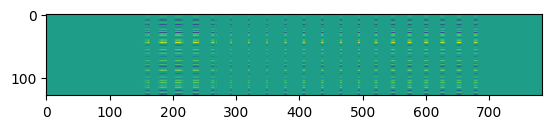

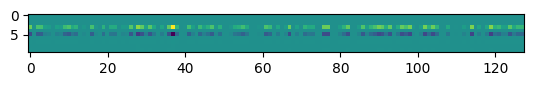

In [57]:
# backward, ours

# dloss/dout
# out: (sample, 10)
# loss: (sample)

# forword
x = X_train[0:1].reshape((-1, 28*28))
tl1 = x.dot(l1)
print(tl1.shape, x.shape, l1.shape)
trelu = np.maximum(0, tl1) # relu

# W = trelu, x = l2, feels inverted...
tl2 = trelu.dot(l2)
print(tl2.shape, trelu.shape, l2.shape)

# log softmax
tden = np.log(np.exp(tl2).sum())
tsoft = tl2 - tden

out = tsoft
print(out)

# nll, take label component and neagte
tloss = -out[range(out.shape[0]), Y_train[0:1]]

# backward

# gradient of NLL, i.e. dL/dout
dout = np.zeros(out.shape)
dout[range(dout.shape[0]), Y_train[0:1]] = -1.0

# gradient of log_softmax, i.e. dL/dsoft = dL/dout * dout/dtl2
# use pytorch to help us a little bit
torch_tl2 = tensor(tl2, requires_grad=True)
torch_tl2.retain_grad()
torch_out = torch.functional.F.log_softmax(torch_tl2, dim=1)
torch_out.retain_grad()
torch_loss = torch.functional.F.nll_loss(torch_out, tensor(Y_train[0:1]))
torch_loss.backward()
print(torch_out.grad)
print(torch_tl2.grad)
dtl2 = torch_tl2.grad.numpy() # by dsm here, I really mean the input of sm, i.e. softmax, a.k.a tl2, so this should really be named dtl2? confusing

# gradient of dot(l2), dL/drelu and dL/dl2
# input dtl2 (1,10), trelu (1, 128)
# output (128, 10)
dl2 = trelu.T.dot(dtl2)

# input dtl2 (1, 10), l2 (128,10)
# output shape (1, 128)
drelu = dtl2.dot(l2.T)

# gradient of relu, dL/dtl1 = dL/drelu * drelu/dtl1
dtl1 = drelu.copy()
dtl1[(tl1 < 0.0)] = 0.0

# gradient of dot(l1), dL/dx or dL/dl1, but we only want dL/dl1, because we already reached the starting point
# dL/dl1 = dL/dtl1 * dtl1/dl1 = dL/dtl1 * x
# input x (1,784), dtl1 (1, 128)
# output (784, 128)
dl1 = x.T.dot(dtl1)

#print(drelu)
imshow(dl1.T)
plt.figure()
imshow(dl2.T)
   